In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import geopandas as gpd
import math
import pickle
from datetime import datetime

import pymc3 as pm
import arviz as az  ##arviz/arviz/plots/backends/matplotlib/posteriorplot.py az.text{} #format_as_percent(hdi_prob) + " HDI",
import arviz.labels as azl
from theano import shared
import theano.tensor as tt

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_data( train_name, test_name, data_type=None):
        data_path = '/home/sevin/Desktop/projects/TravelTime_Prediction/HBRegression/TT_pred_wHBR/data/modeling_data/{}/'.format(data_type)
        train_df = pd.read_csv(data_path + train_name) #'train_wpreds_1.txt'
        # print(self.train_df['Orgn_Drgn'].unique())
        # exit()
        test_df = pd.read_csv(data_path + test_name) #'test_wpreds_1.txt'
        with open(data_path + 'scale_parameters.pickle', 'rb') as handle:
            scale_parameters = pickle.load(handle)
        
        variables_means = scale_parameters['means']
        variables_stds = scale_parameters['stds']
        # print(self.test_df)
        # exit()
        
        return train_df, test_df, variables_means, variables_stds

In [3]:
def load_model(data_type, model_name, ppc_test_name=None):
    save_path = '/home/sevin/Desktop/projects/TravelTime_Prediction/HBRegression/TT_pred_wHBR/trained_models/{}/hbr/'.format(data_type)
    trace = az.from_netcdf(save_path + model_name) #"model_1_itrace_2022-06-01 16:16:09.nc"
    ppc = trace.posterior_predictive
    with open(save_path + ppc_test_name, 'rb') as buff:
        ppc_test = pickle.load(buff) 
    return trace, ppc, ppc_test

In [7]:
def plot_everything(miles, miles_tst, ppc_test, trace, direct=False, logdirect = False, logn = False, hist_plot=True):
    plt.rcParams["font.size"] = 22
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelsize"] = '22'#18
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["xtick.labelsize"] = '22'#"17"
    plt.rcParams["ytick.labelsize"] = '22' #"18"
    plt.rcParams['axes.titlesize'] ='22'#'16'
    plt.rcParams['legend.fontsize'] = '22'#'16'
    plt.rcParams['xtick.major.size'] = '4'
    if logn:
        target_ = 'unitDist_TT_hpm'
        target = 'travel_time(min)'
        predMean_target_name = 'hbr_tt_predMean_logn'
        predStd_target_name = 'hbr_tt_predStd_logn'
    
    elif logdirect:
        target_ = 'travel_time(min)'
        target = 'travel_time(min)'
        predMean_target_name = 'hbr_tt_predMean_logdirect'
        predStd_target_name = 'hbr_tt_predStd_logdirect'

    elif direct:
        target_ = 'travel_time(min)'
        target = 'travel_time(min)'
        predMean_target_name = 'hbr_tt_predMean_direct'
        predStd_target_name = 'hbr_tt_predStd_direct'
    else:
        target_ = 'unitDist_TT_hpm'
        target = 'travel_time(min)'
        predMean_target_name = 'hbr_tt_predMean'
        predStd_target_name = 'hbr_tt_predStd'

    if False:
        ### plot likelihood
        fig, ax = plt.subplots(figsize=(12, 6))
        # az.plot_ppc(trace, group='prior',  ax=ax)
        az.plot_ppc(trace, group='posterior', ax=ax)
        ax.set_xlabel('travel time (hpm)')
    if hist_plot:
        if logn:
            ppc_tt = trace.map(lambda x: x * miles *60, groups="observed_vars").posterior_predictive

        ppc = trace.posterior_predictive

        if logn:
            ncols = 2
            fig, ax = plt.subplots(ncols = ncols, figsize=(12*ncols,12))
            # sns.set(font_scale = 1.8)
            nplt = 500
            for ind in range(nplt):
                if ind%100==0:
                    print(ind)
                d = ppc['y'][0,ind,:]
                if ind == 0:
                    sns.histplot(x = d, stat="density", common_norm=False, ax=ax[0], color='royalblue',element="step", fill=False,
                                                                                label='Posterior predictive on train data')
                else:
                    sns.histplot(x = d, stat="density", common_norm=False, element="step", fill=False, ax=ax[0], color='royalblue')
                # ax[0].set_xlabel('Travel Time (min)', fontsize=22, fontdict={'weight': 'bold'})
                # ax[0].set_ylabel('Density', fontsize=22, fontdict={'weight': 'bold'})
                # ax[0].set_xticklabels((ax[0].get_xticks()/60.).astype(int), size = 22, fontdict={'weight': 'bold'})
                # ax[0].set_yticklabels(ax[0].get_yticks(), size = 22, fontdict={'weight': 'bold'})
            sns.histplot(x = train_df[target_], stat="density", common_norm=False, ax=ax[0], color='black',
                                                                                    element="step", fill=False, ls="-", label='Train data')
            sns.histplot(x = ppc['y'][0].values.flatten(), stat="density", common_norm=True,
                                            element="step", fill=False, ax=ax[0], color='r', ls="--", label='Posterior predictive mean on train data')
            ax[0].set_xlim(right=0.8)
            ax[0].legend()
            ax[0].set_xlabel('Unit-distance travel time (hpm)')

            for ind in range(nplt):
                if ind%100==0:
                    print(ind)
                d = ppc_tt['y'][0,ind,:]
                if ind == 0:
                    sns.histplot(x = d, stat="density", common_norm=False, ax=ax[1], color='royalblue',element="step", fill=False,
                                                                                    label='Posterior predictive on train data')
                else:
                    sns.histplot(x = d, stat="density", common_norm=False, element="step", fill=False, ax=ax[1], color='royalblue')
                        # ax[0].set_xlabel('Travel Time (min)', fontsize=22, fontdict={'weight': 'bold'})
                        # ax[0].set_ylabel('Density', fontsize=22, fontdict={'weight': 'bold'})
                        # ax[0].set_xticklabels((ax[0].get_xticks()/60.).astype(int), size = 22, fontdict={'weight': 'bold'})
                        # ax[0].set_yticklabels(ax[0].get_yticks(), size = 22, fontdict={'weight': 'bold'})
            sns.histplot(x = train_df[target], stat="density", common_norm=False, ax=ax[1], color='black',
                                                                                    element="step", fill=False, ls="-", label='Train data')
            sns.histplot(x = ppc_tt['y'][0].values.flatten(), stat="density", common_norm=True,
                                                element="step", fill=False, ax=ax[1], color='r', ls="--", label='Posterior predictive mean on train data')
            ax[1].set_xlim(right = 50)
            ax[1].legend()
            ax[1].set_xlabel('Travel time(min)')
        else:
            ncols = 2
            fig, ax = plt.subplots(ncols = ncols, figsize=(12*ncols ,12))
            # sns.set(font_scale = 1.8)
            nplt = 200
            for ind in range(nplt):
                if ind%100==0:
                    print(ind)
                d = ppc['y'][0,ind,:]
                if ind == 0:
                    sns.histplot(x = d, stat="density", common_norm=False, ax=ax[0], color='royalblue',element="step", fill=False,
                                                                                label='Posterior predictive on unseen data')
                else:
                    sns.histplot(x = d, stat="density", common_norm=False, element="step", fill=False, ax=ax[0], color='royalblue')
                # ax[0].set_xlabel('Travel Time (min)', fontsize=22, fontdict={'weight': 'bold'})
                # ax[0].set_ylabel('Density', fontsize=22, fontdict={'weight': 'bold'})
                # ax[0].set_xticklabels((ax[0].get_xticks()/60.).astype(int), size = 22, fontdict={'weight': 'bold'})
                # ax[0].set_yticklabels(ax[0].get_yticks(), size = 22, fontdict={'weight': 'bold'})
            sns.histplot(x = train_df[target], stat="density", common_norm=False, ax=ax[0], color='black',
                                                                                element="step", fill=False, ls="-", label='unseen data')
            sns.histplot(x = ppc['y'][0].values.flatten(), stat="density", common_norm=True, 
                                                element="step", fill=False, ax=ax[0], color='orange', ls="--", label='Posterior predictive mean on unseen data')
            ax[0].set_xlim(right = 50)
            ax[0].legend()
            ax[0].set_xlabel(target)
        
        converted_ppc_test = ppc_test['y'] * miles_tst * 60
        fig, ax = plt.subplots(ncols = 2, figsize=(12 * 2, 12))
        # sns.set(font_scale = 1.8)
        nplt = 500
        for ind in range(nplt):
            if ind%100==0:
                print(ind)
            d = ppc_test['y'][ind,:]
            if ind == 0:
                sns.histplot(x = d, stat="density", common_norm=False, element="step", fill=False, 
                                                 ax=ax[0], color='royalblue',  label='Posterior predictive on test data')
            else:
                sns.histplot(x = d, stat="density", common_norm=False, element="step", fill=False,  ax=ax[0], color='royalblue')
            # ax[0].set_xlabel('Travel Time (min)', fontsize=22, fontdict={'weight': 'bold'})
            # ax[0].set_ylabel('Density', fontsize=22, fontdict={'weight': 'bold'})
            # ax[0].set_xticklabels((ax[0].get_xticks()/60.).astype(int), size = 22, fontdict={'weight': 'bold'})
            # ax[0].set_yticklabels(ax[0].get_yticks(), size = 22, fontdict={'weight': 'bold'})
        sns.histplot(x = test_df['unitDist_TT_hpm'], stat="density", common_norm=False, element="step", fill=False,  ax=ax[0], color='black', ls="-", label='Test data')
        sns.histplot(x = ppc_test['y'].flatten(), stat="density", common_norm=False, element="step",
                                         fill=False,  ax=ax[0], color='orange', ls="--", label='Posterior predictive mean on test data')
        ax[0].set_xlim(right=0.8)
        ax[0].legend()
        ax[0].set_xlabel('Unit-distance travel time (hpm)')

        for ind in range(nplt):
            if ind%100==0:
                print(ind)
            d = converted_ppc_test[ind,:]
            if ind == 0:
                sns.histplot(x = d, stat="density", common_norm=False, element="step", fill=False,
                                          ax=ax[1], color='royalblue',  label='Posterior predictive on test data')
            else:
                sns.histplot(x = d, stat="density", common_norm=False, element="step", fill=False,  ax=ax[1], color='royalblue')
            # ax[0].set_xlabel('Travel Time (min)', fontsize=22, fontdict={'weight': 'bold'})
            # ax[0].set_ylabel('Density', fontsize=22, fontdict={'weight': 'bold'})
            # ax[0].set_xticklabels((ax[0].get_xticks()/60.).astype(int), size = 22, fontdict={'weight': 'bold'})
            # ax[0].set_yticklabels(ax[0].get_yticks(), size = 22, fontdict={'weight': 'bold'})
        sns.histplot(x = test_df['travel_time(min)'], stat="density", common_norm=False, element="step", 
                                                                    fill=False,  ax=ax[1], color='black', ls="-", label='Test data')
        sns.histplot(x = converted_ppc_test.flatten(), stat="density", common_norm=False, element="step",
                                                     fill=False,  ax=ax[1], color='orange', ls="--", label='Posterior predictive mean on test data')
        ax[1].set_xlim(right=40)
        ax[1].legend()
        ax[1].set_xlabel('Travel time (min)')

    ### plot fixed parameters posteriors
    if direct or logdirect:
        fixed_params = ["Beta0", "Beta1",'Beta2','Beta3', 'Beta4', 'Beta5']
        labeller = azl.MapLabeller(var_name_map={"Beta0": r"$\beta_0$", "Beta1": r"$\beta_1$","Beta2": r"$\beta_2$", "Beta3": r"$\beta_3$",
                                                 "Beta4": r"$\beta_4$","Beta5": r"$\beta_5$",'b0_region':'$r_{,0}$', 'b1_region':'$r_{,1}$',
                                                  'b2_region':'$r_{,2}$', 'b3_region':'$r_{,3}$','b4_region':'$r_{,4}$','b5_region':'$r_{,5}$',
                                                  "sigma_b0": r"$\sigma_h$", 'sigma_b1': r"$\sigma_{r_1}$", 'sigma_b2':r"$\sigma_{r_2}$", 
                                                'sigma_b3':r"$\sigma_{r_3}$", 'sigma_b4':r"$\sigma_{r_4}$", 'sigma_b5':r"$\sigma_{r_5}$"})
    else:
        fixed_params = ["Beta0", "Beta1",'Beta2','Beta3', 'Beta4']
        labeller = azl.MapLabeller(var_name_map={"Beta0": r"$\beta_0$", "Beta1": r"$\beta_1$","Beta2": r"$\beta_2$", "Beta3": r"$\beta_3$", "Beta4": r"$\beta_4$",
                                                'b0_region':r'$b_{0,j}^t$', 'b1_region':r'$b_{1,j}$', 'b2_region':r'$b_{1,j}$', 'b3_region':r'$b_{3,j}$',
                                                'b4_region':r'$r_{4,j}$',
                                                "sigma_b0": r"$\sigma_h$", 'sigma_b1': r"$\sigma_{r_1}$", 'sigma_b2':r"$\sigma_{r_2}$", 
                                                'sigma_b3':r"$\sigma_{r_3}$", 'sigma_b4':r"$\sigma_{r_4}$",
                                                'b0':r"$\mu_h$", 'b1':r"$\mu_{r_1}$", 'b2':r"$\mu_{r_2}}$", 'b3':r"$\mu_{r_3}$", 'b4':r"$\mu_{r_4}$" })
    fig, ax = plt.subplots(ncols=len(fixed_params), figsize=(5*len(fixed_params),4) ) #, gridspec_kw={'width_ratios': [4,4,5, 4]} , gridspec_kw={'width_ratios': [5,5,5,5,5,5]}
    
    for i, var in enumerate(fixed_params):
        if i==0:
            az.plot_posterior(trace, var_names=var, transform = np.exp ,labeller=labeller,  color='r', ax = ax[i])
        else:
            az.plot_posterior(trace, var_names=var, transform = np.exp ,labeller=labeller,  color='r', ax = ax[i]) #ref_val=0,
    
    
    if direct or logdirect:
        fixed_params = ['sigma_b0','sigma_b1','sigma_b2','sigma_b3','sigma_b4','sigma_b5']
    else:
        fixed_params = ['sigma_b0','sigma_b1','sigma_b2','sigma_b3','sigma_b4']

    fig, ax = plt.subplots(ncols=len(fixed_params), figsize=(5*len(fixed_params),4) ) #, gridspec_kw={'width_ratios': [5,6,5,5,5, 5]} 
    for i, var in enumerate(fixed_params):
        az.plot_posterior(trace, var_names=var, labeller = labeller,  color='r', ax=ax[i])
    ######
    if direct or logdirect:
        fixed_params = ['b0','b1','b2','b3','b4','b5']
    else:
        fixed_params = ['b0','b1','b2','b3','b4']

    fig, ax = plt.subplots(ncols=len(fixed_params), figsize=(5*len(fixed_params),4) ) #, gridspec_kw={'width_ratios': [5,6,5,5,5, 5]} 
    for i, var in enumerate(fixed_params):
        az.plot_posterior(trace, var_names=var, labeller = labeller,  color='r', ax=ax[i])
    
    ### plot noises
    labeller_ = azl.MapLabeller(var_name_map={"sigma": r"$\sigma$"})
    axes = az.plot_forest(
        trace, var_names=['sigma'],
        kind='ridgeplot',
        colors='r',
        hdi_prob=0.95,
        ridgeplot_quantiles=[.25, .5, .75],
        ridgeplot_truncate=False,
        labeller = labeller_,
        ridgeplot_alpha = 0
        )

    ### plot time effect
    if True:
        fig, ax = plt.subplots(figsize=(28,14))
        line_styles = ['.:', '.--', '.-','.-.', 'v--', 'v:', 'v-']
        region_pairs = ['South_South', 'North_Central', 'North_North', 'Central_Central',
                                'Central_North', 'Central_South', 'South_Central']
        for i, obj in enumerate(zip(line_styles,region_pairs)):
            style = obj[0]
            region = obj[1]
            mean = az.summary(np.exp(trace.posterior['Beta0'] + trace.posterior['b0_region'].sel(region_pairs=region).to_dataset()))['mean'].values
            sd = az.summary(np.exp(trace.posterior['Beta0'] + trace.posterior['b0_region'].sel(region_pairs=region).to_dataset()))['sd'].values
            # mean_ln = az.summary(trace.posterior['Beta0'] + trace.posterior['b0_region'].sel(region_pairs=region).to_dataset())['mean'].values
            # sd_ln = az.summary(trace.posterior['Beta0'] + trace.posterior['b0_region'].sel(region_pairs=region).to_dataset())['sd'].values
            # mean = np.exp(mean_ln + 0.5 * sd_ln**2)
            # sd = mean * np.sqrt(np.exp(sd_ln**2) - 1)
            _ = ax.plot(np.arange(24), mean, style, linewidth=3,markersize=10, label=region)
            _ = ax.fill_between(x = np.arange(24), y1= mean - sd, y2 = mean + sd, alpha=0.3)
            _= ax.set_xticks(np.arange(24))
        ax.set_xlabel('hour',fontsize=22)
        ax.set_ylabel(' Median ud-tarvel time (hpm)'+'-exp(' + r"$\beta_0$" +'+'+ '$b_{0,j}^t$)',fontsize=22)
        ax.legend(fontsize=18, ncol=4)
        ax.tick_params(axis='both', which='major', labelsize=22)
    
        ### compare trend of time effect vs observation
    
        cross_average = pd.DataFrame(train_df[['hour','Orgn_Drgn',target_]].groupby(['Orgn_Drgn','hour']).mean()).reset_index(drop=False)
        fig, ax = plt.subplots(nrows = 7, figsize=(24,28))
        for i, rgn in enumerate(cross_average['Orgn_Drgn'].unique()):
            tmp = cross_average[cross_average['Orgn_Drgn']==rgn]
            ax[i].plot(tmp['hour'], tmp[target_], label='{}(obs.)'.format(rgn))
            tmp_ax = ax[i].twinx()
            _ = tmp_ax.plot(np.arange(24), az.summary(trace.posterior['b0_region'].sel(region_pairs=rgn).to_dataset())['mean'].values,'.--', label='{}(model)'.format(rgn))
            _= ax[i].set_xticks(np.arange(24))
            ax[i].set_xticks(np.arange(24))
            ax[i].legend(fontsize=22, ncol=3)
    ###
    if False:
        if direct:
            fig, ax = plt.subplots(nrows=8, ncols=5, figsize=(25,32) )
            # az.plot_posterior(trace, var_names=["Beta0"], grid=(1,1), labeller=labeller, color='k')
            # az.plot_posterior(trace, var_names=["Beta0",'b0_region'], grid=(8,1),  labeller=labeller, color='r', ax=ax[:,0])
            
            az.plot_posterior(trace, var_names=["Beta1",'b1_region'], ref_val=0, grid=(8,1), labeller=labeller, color='r', ax=ax[:,0])
            az.plot_posterior(trace, var_names=["Beta2",'b2_region'], ref_val=0, grid=(8,1), labeller=labeller, color='r', ax=ax[:,1])
            az.plot_posterior(trace, var_names=["Beta3",'b3_region'], ref_val=0, grid=(8,1), labeller=labeller, color='r', ax=ax[:,2])
            az.plot_posterior(trace, var_names=["Beta4",'b4_region'], ref_val=0, grid=(8,1), labeller=labeller, color='r', ax=ax[:,3])
            az.plot_posterior(trace, var_names=["Beta5",'b5_region'], ref_val=0, grid=(8,1), labeller=labeller, color='r', ax=ax[:,4])
        else:
            fig, ax = plt.subplots(nrows=8, ncols=4, figsize=(20,32) )
            # az.plot_posterior(trace, var_names=["Beta0"], grid=(1,1), labeller=labeller, color='k')
            # az.plot_posterior(trace, var_names=["Beta0",'b0_region'], grid=(8,1),  labeller=labeller, color='r', ax=ax[:,0])
            az.plot_posterior(trace, var_names=["Beta1",'b1_region'], ref_val=0, grid=(8,1), labeller=labeller, color='r', ax=ax[:,0])
            az.plot_posterior(trace, var_names=["Beta2",'b2_region'], ref_val=0, grid=(8,1), labeller=labeller, color='r', ax=ax[:,1])
            az.plot_posterior(trace, var_names=["Beta3",'b3_region'], ref_val=0, grid=(8,1), labeller=labeller, color='r', ax=ax[:,2])
            az.plot_posterior(trace, var_names=["Beta4",'b4_region'], ref_val=0, grid=(8,1), labeller=labeller, color='r', ax=ax[:,3])

    if direct:
        fig, ax = plt.subplots(nrows=7, ncols=6, figsize=(28,58) )
        # az.plot_posterior(trace, var_names=["Beta0"], grid=(1,1), labeller=labeller, color='k')
        # az.plot_posterior(trace, var_names=["Beta0",'b0_region'], grid=(8,1),  labeller=labeller, color='r', ax=ax[:,0])
        label = azl.MapLabeller(var_name_map={"x": 'exp(' + r"$\beta_0 + b_{0,j}^t $" + ')'})
        az.plot_posterior(trace.posterior['Beta0'] + trace.posterior['b0_region'].mean(dim=('hours')),  grid=(7,1), labeller=label, color='r', ax=ax[:,0])
        label = azl.MapLabeller(var_name_map={"x": 'exp(' + r"$\beta_1 + b_{1,j} $" + ')'})
        az.plot_posterior(trace.posterior['Beta1'] + trace.posterior['b1_region'], ref_val=0, grid=(7,1), labeller=labeller, color='r', ax=ax[:,1])
        label = azl.MapLabeller(var_name_map={"x": 'exp(' + r"$\beta_2 + b_{2,j} $" + ')'})
        az.plot_posterior(trace.posterior['Beta2'] + trace.posterior['b2_region'], ref_val=0, grid=(7,1), labeller=labeller, color='r', ax=ax[:,2])
        label = azl.MapLabeller(var_name_map={"x": 'exp(' + r"$\beta_3 + b_{3,j} $" + ')'})
        az.plot_posterior(trace.posterior['Beta3'] + trace.posterior['b3_region'], ref_val=0, grid=(7,1), labeller=labeller, color='r', ax=ax[:,3])
        label = azl.MapLabeller(var_name_map={"x": 'exp(' + r"$\beta_4 + b_{4,j} $" + ')'})
        az.plot_posterior(trace.posterior['Beta4'] + trace.posterior['b4_region'], ref_val=0, grid=(7,1), labeller=labeller, color='r', ax=ax[:,4])
        label = azl.MapLabeller(var_name_map={"x": 'exp(' + r"$\beta_5 + b_{5,j} $" + ')'})
        az.plot_posterior(trace.posterior['Beta5'] + trace.posterior['b5_region'], ref_val=0, grid=(7,1), labeller=labeller, color='r', ax=ax[:,5])
    else:
        fig, ax = plt.subplots(nrows=7, ncols=5, figsize=(40,60) ) #, sharex='col'
        label = azl.MapLabeller(var_name_map={"x": 'exp(' + r"$\beta_0 + b_{0,j} $" + ')'})
        az.plot_posterior(trace.posterior['Beta0'] + trace.posterior['b0_region'].mean(dim=('hours')), transform=np.exp, grid=(7,1), labeller=label, color='r',
                                                                                                     ax=ax[:,0])
        label = azl.MapLabeller(var_name_map={"x": 'exp(' + r"$\beta_1 + b_{1,j} $" + ')'})
        az.plot_posterior(trace.posterior['Beta1'] + trace.posterior['b1_region'], ref_val=1, grid=(7,1), transform=np.exp,round_to=3,labeller=label, color='r', ax=ax[:,1])
        label = azl.MapLabeller(var_name_map={"x": 'exp(' + r"$\beta_2 + b_{2,j} $" + ')'})
        az.plot_posterior(trace.posterior['Beta2'] + trace.posterior['b2_region'], ref_val=1, grid=(7,1), transform=np.exp,round_to=3, labeller=label, color='r', ax=ax[:,2])
        label = azl.MapLabeller(var_name_map={"x": 'exp(' + r"$\beta_3 + b_{3,j} $" + ')'})
        az.plot_posterior(trace.posterior['Beta3'] + trace.posterior['b3_region'], ref_val=1, grid=(7,1), transform=np.exp,round_to=3, labeller=label, color='r', ax=ax[:,3])
        label = azl.MapLabeller(var_name_map={"x": 'exp(' + r"$\beta_4+ b_{4,j} $" + ')'})
        az.plot_posterior(trace.posterior['Beta4'] + trace.posterior['b4_region'], ref_val=1, grid=(7,1), transform=np.exp,round_to=3, labeller=label, color='r', ax=ax[:,4])
    if True:
        col = 4
        fig, ax = plt.subplots(nrows = 7, ncols = col, figsize=(7* col, 6 *7), sharex='col')
        
        ### plot peredictions vs ground truth per region
        pairs = train_df['Orgn_Drgn'].unique()
        for p in range(len(pairs)):
            pair = pairs[p]
            d = train_df[train_df['Orgn_Drgn']==pair]
            errors =  d[target][:] - d[predMean_target_name][:]
            # sq_errors = (d['travel_time'][:]/60. - d['predictions1'][:]/60.)**2

            d_tst = test_df[test_df['Orgn_Drgn']==pair]
            errors_tst =  d_tst[target][:] - d_tst[predMean_target_name][:]

            

            ax[p,0].errorbar(x = d[target][:], y = d[predMean_target_name][:], yerr= d[predStd_target_name][:], fmt='.', alpha=0.4, label=pair)
            ax[p,0].plot([0,50],[0,50], color='k')
            # ax[p,0].set_xlabel('observed (min)', fontsize=22, fontdict={'weight': 'bold'})
            ax[p,0].set_ylabel('predicted (min)', fontsize=22, fontdict={'weight': 'bold'})
            # ax[0].set_yticklabels(ax[0].get_yticks().astype(int), size = 22, fontdict={'weight': 'bold'})
            # ax[0].set_xticklabels(ax[0].get_xticks().astype(int), size = 22, fontdict={'weight': 'bold'})
            ax[p,0].tick_params(axis='both', which='major', labelsize=22)
            ax[p,0].legend(fontsize=22)

            _ = ax[p,1].hist(errors, bins=50, density=True)
            mean_rmse = np.sqrt(mean_squared_error(d[target][:], d[predMean_target_name][:]))
            std_rmse = np.std(errors)
            _=ax[p,1].set_title(" Train: RMSE = {:.2f} $\pm$ {:.2f} (min)".format(mean_rmse,std_rmse),fontsize=22, fontdict={'weight': 'bold'})
            # ax[p,1].set_xlabel('error(min)', fontsize=22, fontdict={'weight': 'bold'})
            # ax[1].set_yticklabels(ax[1].get_yticks(), size = 22, fontdict={'weight': 'bold'})
            # ax[1].set_xticklabels(np.round(ax[1].get_xticklabels(),1), size = 22, fontdict={'weight': 'bold'})
            ax[p,1].tick_params(axis='both', which='major', labelsize=22)
            ax[p,1].set_ylabel('')
            ax[p,1].set_yticks([])

            ax[p,2].errorbar(x = d_tst[target][:], y = d_tst[predMean_target_name][:], yerr= d_tst[predStd_target_name][:], fmt='r.', alpha=0.4, label=pair)
            ax[p,2].plot([0,50],[0,50], color='k')
            # ax[p,2].set_xlabel('observed (min)', fontsize=22, fontdict={'weight': 'bold'})
            # ax[2].set_ylabel('predicted (min)', fontsize=22, fontdict={'weight': 'bold'})
            # ax[2].set_yticklabels(ax[2].get_yticks().astype(int), size = 22, fontdict={'weight': 'bold'})
            # ax[2].set_xticklabels(ax[2].get_xticks().astype(int), size = 22, fontdict={'weight': 'bold'})
            ax[p,2].tick_params(axis='both', which='major', labelsize=22)
            ax[p,2].legend(fontsize=22)

            _ = ax[p,3].hist(errors_tst, bins=50, density=True, color='r')
            # ax[3].set_yticklabels(ax[3].get_yticks(), size = 22, fontdict={'weight': 'bold'})
            # ax[3].set_xticklabels(ax[3].get_xticks(), size = 22, fontdict={'weight': 'bold'})
            ax[p,3].tick_params(axis='both', which='major', labelsize=22)
            mean_rmse_tst = np.sqrt(mean_squared_error(d_tst[target][:],d_tst[predMean_target_name][:]))
            std_rmse_tst = np.std(errors_tst)
            _=ax[p,3].set_title(" Test: RMSE = {:.2f} $\pm$ {:.2f} (min)".format(mean_rmse_tst, std_rmse_tst), fontsize=22, fontdict={'weight': 'bold'} )
            # ax[p,3].set_xlabel('error(min)', fontsize=22, fontdict={'weight': 'bold'})
            ax[p,3].set_ylabel('')
            ax[p,3].set_yticks([])
        ax[-1,1].set_xlabel('error(min)', fontsize=22, fontdict={'weight': 'bold'})
        ax[-1,3].set_xlabel('error(min)', fontsize=22, fontdict={'weight': 'bold'})
        ax[-1,0].set_xlabel('observed (min)', fontsize=22, fontdict={'weight': 'bold'})
        ax[-1,2].set_xlabel('observed (min)', fontsize=22, fontdict={'weight': 'bold'})
        plt.show()
    if False:
        col = 2
        d = train_df
        fig, ax = plt.subplots(nrows = col, figsize=(12,12), sharex=True)
        ax[0].plot(np.log(d.groupby('Oatom_Datom')['Oatom_Datom'].count()), (d.groupby('Oatom_Datom')[target].mean() - d.groupby('Oatom_Datom')[predMean_target_name].mean())/d.groupby('Oatom_Datom')['travel_time'].mean()/60., 'b.')
        ax[0].set_ylabel('Relative prediction error (min)', fontsize=22, fontdict={'weight': 'bold'})
        # ax[0].set_xlabel('log trip count', fontsize=22, fontdict={'weight': 'bold'})
        # ax[0].legend()
        ax[0].plot([0,5.5], [0,0], 'k')
        ax[0].tick_params(axis='both', which='major', labelsize=22)
        ax[0].set_title(pair, fontsize=22, fontdict={'weight': 'bold'} )

        ax[1].plot(np.log(d.groupby('Oatom_Datom')['Oatom_Datom'].count()), d.groupby('Oatom_Datom')[target].mean(),
                                                                         'bo', label='observed travel time', alpha=0.3)
        ax[1].plot(np.log(d.groupby('Oatom_Datom')['Oatom_Datom'].count()), d.groupby('Oatom_Datom')[predMean_target_name].mean(),
                                                                                 'ro', label='predicted tarvel time', alpha=0.3)
        ax[1].set_ylabel('Average travel time (min)', fontsize=22, fontdict={'weight': 'bold'})
        ax[1].set_xlabel('Log trip count', fontsize=22, fontdict={'weight': 'bold'})
        ax[1].legend(fontsize=22)
        ax[1].tick_params(axis='both', which='major', labelsize=22)
    if True:
        ### plot prediction performance vs data count 
        # for pair in train_df['Orgn_Drgn'].unique():
        if True:
            # d = train_df[train_df['Orgn_Drgn']==pair]
            d=train_df
            y_true = d.groupby('Oatom_Datom')[target].mean().values
            y_pred = d.groupby('Oatom_Datom')[predMean_target_name].mean().values
            avg_std_pred = d.groupby('Oatom_Datom')[predStd_target_name].mean().values
            # errors =  d['travel_time'][:]/60 - d['predictions2'][:]/60
            
            col = 2
            fig, ax = plt.subplots(nrows = col, figsize=(12,12), sharex=True) #, gridspec_kw={'width_ratios': [1,2,2]}
            # ax[0].errorbar(x = y_true, y = y_pred, yerr= avg_std_pred, fmt='.', alpha=0.4, label=pair)
            # ax[0].plot([0,50],[0,50])
            # ax[0].set_xlabel('Observed (min)', fontsize=22, fontdict={'weight': 'bold'})
            # ax[0].set_ylabel('Predicted (min)', fontsize=22, fontdict={'weight': 'bold'})
            # ax[0].legend(fontsize=22)
            # ax[0].tick_params(axis='both', which='major', labelsize=22)
            # _ = ax[1].hist(errors, bins=50)
            # _=ax[1].set_title(" RMSE evaluated = {:.2f} min".format(np.sqrt(mean_squared_error(d['travel_time'][:]/60,d['predictions2'][:]/60.))))
            # ax[1].set_xlabel('error(min)')
            ax[0].plot(np.log(d.groupby('Oatom_Datom')['Oatom_Datom'].count()), (d.groupby('Oatom_Datom')[target].mean() - d.groupby('Oatom_Datom')[predMean_target_name].mean())/d.groupby('Oatom_Datom')['travel_time'].mean()/60., 'b.', label=pair)
            ax[0].set_ylabel('Relative prediction error (min)', fontsize=22, fontdict={'weight': 'bold'})
            # ax[0].set_xlabel('log trip count', fontsize=22, fontdict={'weight': 'bold'})
            # ax[0].legend()
            ax[0].plot([0,5.5], [0,0], 'k')
            ax[0].tick_params(axis='both', which='major', labelsize=22)
            # ax[0].set_title(pair, fontsize=22, fontdict={'weight': 'bold'} )

            ax[1].plot(np.log(d.groupby('Oatom_Datom')['Oatom_Datom'].count()), d.groupby('Oatom_Datom')[target].mean(), 'bo', label='observed travel time', alpha=0.3)
            ax[1].plot(np.log(d.groupby('Oatom_Datom')['Oatom_Datom'].count()), d.groupby('Oatom_Datom')[predMean_target_name].mean(), 'ro', label='predicted tarvel time', alpha=0.3)
            ax[1].set_ylabel('Average travel time (min)', fontsize=22, fontdict={'weight': 'bold'})
            ax[1].set_xlabel('Log trip count', fontsize=22, fontdict={'weight': 'bold'})
            ax[1].legend(fontsize=22)
            ax[1].tick_params(axis='both', which='major', labelsize=22)

In [106]:
def plot_hist(miles, miles_tst, ppc_test, trace, direct=False, logdirect = False, logn = False, hist_plot=True):
    plt.rcParams["font.size"] = 22
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelsize"] = '22'#18
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["xtick.labelsize"] = '22'#"17"
    plt.rcParams["ytick.labelsize"] = '22' #"18"
    plt.rcParams['axes.titlesize'] ='22'#'16'
    plt.rcParams['legend.fontsize'] = '22'#'16'
    plt.rcParams['xtick.major.size'] = '4'
    if logn:
        target_ = 'unitDist_TT_hpm'
        target = 'travel_time(min)'
        predMean_target_name = 'hbr_tt_predMean_logn'
        predStd_target_name = 'hbr_tt_predStd_logn'
    
    elif logdirect:
        target_ = 'travel_time(min)'
        target = 'travel_time(min)'
        predMean_target_name = 'hbr_tt_predMean_logdirect'
        predStd_target_name = 'hbr_tt_predStd_logdirect'

    elif direct:
        target_ = 'travel_time(min)'
        target = 'travel_time(min)'
        predMean_target_name = 'hbr_tt_predMean_direct'
        predStd_target_name = 'hbr_tt_predStd_direct'
    else:
        target_ = 'unitDist_TT_hpm'
        target = 'travel_time(min)'
        predMean_target_name = 'hbr_tt_predMean'
        predStd_target_name = 'hbr_tt_predStd'

    if False:
        ### plot likelihood
        fig, ax = plt.subplots(figsize=(12, 6))
        # az.plot_ppc(trace, group='prior',  ax=ax)
        az.plot_ppc(trace, group='posterior', ax=ax)
        ax.set_xlabel('travel time (hpm)')
    if hist_plot:
        if logn:
            ppc_tt = trace.map(lambda x: x * miles *60, groups="observed_vars").posterior_predictive

        ppc = trace.posterior_predictive

        if logn:
            ncols = 2
            fig, ax = plt.subplots(ncols = ncols, figsize=(12*ncols,12))
            # sns.set(font_scale = 1.8)
            nplt = 500
            # # # for ind in range(nplt):
            # # #     if ind%100==0:
            # # #         print(ind)
            # # #     d = ppc['y'][0,ind,:]
            # # #     if ind == 0:
            # # #         sns.histplot(x = d, stat="density", common_norm=False, ax=ax[0], color='royalblue',element="step", fill=False, alpha = 0.5,
            # # #                                                                     label='Posterior predictive')
            # # #     else:
            # # #         sns.histplot(x = d, stat="density", common_norm=False, element="step", fill=False, ax=ax[0], color='royalblue')
            # # #     # ax[0].set_xlabel('Travel Time (min)', fontsize=22, fontdict={'weight': 'bold'})
            # # #     # ax[0].set_ylabel('Density', fontsize=22, fontdict={'weight': 'bold'})
            # # #     # ax[0].set_xticklabels((ax[0].get_xticks()/60.).astype(int), size = 22, fontdict={'weight': 'bold'})
            # # #     # ax[0].set_yticklabels(ax[0].get_yticks(), size = 22, fontdict={'weight': 'bold'})
            # # # sns.histplot(x = train_df[target_], stat="density", common_norm=False, ax=ax[0], color='black',
            # # #                                                                         element="step", fill=False, ls="-", label='Data')
            # # # sns.histplot(x = ppc['y'][0].values.flatten(), stat="density", common_norm=True,
            # # #                                 element="step", fill=False, ax=ax[0], color='r', ls="--", label='Posterior predictive mean')
            # # # ax[0].set_xlim(right=0.8)
            # # # ax[0].legend()
            # # # ax[0].set_xlabel('Unit-distance travel time (hpm)')
                                                                                   
            for ind in range(nplt):
                if ind%100==0:
                    print(ind)
                d = ppc_tt['y'][0,ind,:]
                if ind == 0:
                    sns.histplot(x = d, stat="density", common_norm=False, ax=ax[1], color='royalblue',alpha = 0.5, element="step", binwidth=1, fill=False,
                                                                                    label='Posterior predictive')
                else:
                    sns.histplot(x = d, stat="density", common_norm=False, element="step", binwidth=1, fill=False, ax=ax[1], color='royalblue',alpha = 0.5)
                        # ax[0].set_xlabel('Travel Time (min)', fontsize=22, fontdict={'weight': 'bold'})
                        # ax[0].set_ylabel('Density', fontsize=22, fontdict={'weight': 'bold'})
                        # ax[0].set_xticklabels((ax[0].get_xticks()/60.).astype(int), size = 22, fontdict={'weight': 'bold'})
                        # ax[0].set_yticklabels(ax[0].get_yticks(), size = 22, fontdict={'weight': 'bold'})
            
            sns.histplot(x = ppc_tt['y'][0].values.flatten(), stat="density", common_norm=True,
                                                element="step", binwidth=1, fill=True, ax=ax[1], color='r', ls="-",alpha = 0.01 , label='Posterior predictive mean') 
            sns.histplot(x = ppc_tt['y'][0].values.flatten(), stat="density", common_norm=True,
                                                element="step", binwidth=1, fill=False, ax=ax[1], color='r', ls="-", label='Posterior predictive mean') 
            sns.histplot(x = train_df[target], stat="density", common_norm=False, ax=ax[1], color='black',
                                                                                    element="step", binwidth=1, fill=True, ls="-" ,alpha = 0.01, label='data')
            sns.histplot(x = train_df[target], stat="density", common_norm=False, ax=ax[1], color='black',
                                                                                    element="step", binwidth=1, fill=False, ls="-" , label='data')                                                                        
            
            ax[1].set_xlim(right = 50)
            ax[1].legend()
            ax[1].set_xlabel('Travel time(min)')
            ax[1].legend().set_visible(False)
            

In [43]:
def plot_predictions(miles, miles_tst, ppc_test, trace, direct=False, logdirect = False, logn = False, hist_plot=True):
    plt.rcParams["font.size"] = 22
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelsize"] = '22'#18
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["xtick.labelsize"] = '22'#"17"
    plt.rcParams["ytick.labelsize"] = '22' #"18"
    plt.rcParams['axes.titlesize'] ='22'#'16'
    plt.rcParams['legend.fontsize'] = '22'#'16'
    plt.rcParams['xtick.major.size'] = '4'
    if logn:
        target_ = 'unitDist_TT_hpm'
        target = 'travel_time(min)'
        predMean_target_name = 'hbr_tt_predMean_logn'
        predStd_target_name = 'hbr_tt_predStd_logn'
    
    elif logdirect:
        target_ = 'travel_time(min)'
        target = 'travel_time(min)'
        predMean_target_name = 'hbr_tt_predMean_logdirect'
        predStd_target_name = 'hbr_tt_predStd_logdirect'

    elif direct:
        target_ = 'travel_time(min)'
        target = 'travel_time(min)'
        predMean_target_name = 'hbr_tt_predMean_direct'
        predStd_target_name = 'hbr_tt_predStd_direct'
    else:
        target_ = 'unitDist_TT_hpm'
        target = 'travel_time(min)'
        predMean_target_name = 'hbr_tt_predMean'
        predStd_target_name = 'hbr_tt_predStd'  
    if True:
        col = 3
        rows = 1
        fig, ax = plt.subplots(nrows = 1, ncols = col, figsize=(7* col, rows *7), sharex='col')
        
        ### plot peredictions vs ground truth per region
        pairs = train_df['Orgn_Drgn'].unique()
        
        if True:
        # for p in range(len(pairs)):
            p = 0
            # pair = 'Central_North'
            pair = 'North_Central'
            # pair = pairs[p]
            d = train_df[train_df['Orgn_Drgn']==pair]
            errors =  d[target][:] - d[predMean_target_name][:]
            # sq_errors = (d['travel_time'][:]/60. - d['predictions1'][:]/60.)**2

            d_tst = test_df[test_df['Orgn_Drgn']==pair]
            errors_tst =  d_tst[target][:] - d_tst[predMean_target_name][:]

            ax[0].errorbar(x = d[target][:], y = d[predMean_target_name][:], yerr= d[predStd_target_name][:], fmt='.', alpha=0.4, label='Train')
            ax[0].plot([0,50],[0,50], color='k')
            # ax[p,0].set_xlabel('observed (min)', fontsize=22, fontdict={'weight': 'bold'})
            ax[0].set_ylabel('predicted (min)', fontsize=22, fontdict={'weight': 'bold'})
            # ax[0].set_yticklabels(ax[0].get_yticks().astype(int), size = 22, fontdict={'weight': 'bold'})
            # ax[0].set_xticklabels(ax[0].get_xticks().astype(int), size = 22, fontdict={'weight': 'bold'})
            ax[0].tick_params(axis='both', which='major', labelsize=22)
            ax[0].legend(fontsize=22)
            
            ax[1].errorbar(x = d_tst[target][:], y = d_tst[predMean_target_name][:], yerr= d_tst[predStd_target_name][:], fmt='r.', alpha=0.4, label='Test') #fmt='r.'
            ax[1].plot([0,50],[0,50], color='k')
            # ax[p,2].set_xlabel('observed (min)', fontsize=22, fontdict={'weight': 'bold'})
            # ax[2].set_ylabel('predicted (min)', fontsize=22, fontdict={'weight': 'bold'})
            # ax[2].set_yticklabels(ax[2].get_yticks().astype(int), size = 22, fontdict={'weight': 'bold'})
            # ax[2].set_xticklabels(ax[2].get_xticks().astype(int), size = 22, fontdict={'weight': 'bold'})
            ax[1].tick_params(axis='both', which='major', labelsize=22)
            ax[1].legend(fontsize=22)

            mean_rmse = np.sqrt(mean_squared_error(d[target][:], d[predMean_target_name][:]))
            std_rmse = np.std(errors)
            _ = ax[2].hist(errors, bins=20, density=True, color='b',  alpha = 0.5, label="Train"+'\n'+"RMSE = {:.2f} $\pm$ {:.2f} (min)".format(mean_rmse,std_rmse))
            # _=ax[2].set_title(" Train: RMSE = {:.2f} $\pm$ {:.2f} (min)".format(mean_rmse,std_rmse),fontsize=22, fontdict={'weight': 'bold'})
            # ax[p,1].set_xlabel('error(min)', fontsize=22, fontdict={'weight': 'bold'})
            # ax[1].set_yticklabels(ax[1].get_yticks(), size = 22, fontdict={'weight': 'bold'})
            # ax[1].set_xticklabels(np.round(ax[1].get_xticklabels(),1), size = 22, fontdict={'weight': 'bold'})
            ax[2].tick_params(axis='both', which='major', labelsize=22)
            ax[2].set_ylabel('')
            ax[2].set_yticks([])

            # # # ax[p,0].errorbar(x = d[target][:], y = d[predMean_target_name][:], yerr= d[predStd_target_name][:], fmt='.', alpha=0.4, label=pair)
            # # # ax[p,0].plot([0,50],[0,50], color='k')
            # # # # ax[p,0].set_xlabel('observed (min)', fontsize=22, fontdict={'weight': 'bold'})
            # # # ax[p,0].set_ylabel('predicted (min)', fontsize=22, fontdict={'weight': 'bold'})
            # # # # ax[0].set_yticklabels(ax[0].get_yticks().astype(int), size = 22, fontdict={'weight': 'bold'})
            # # # # ax[0].set_xticklabels(ax[0].get_xticks().astype(int), size = 22, fontdict={'weight': 'bold'})
            # # # ax[p,0].tick_params(axis='both', which='major', labelsize=22)
            # # # ax[p,0].legend(fontsize=22)

            # # # _ = ax[p,1].hist(errors, bins=50, density=True)
            # # # mean_rmse = np.sqrt(mean_squared_error(d[target][:], d[predMean_target_name][:]))
            # # # std_rmse = np.std(errors)
            # # # _=ax[p,1].set_title(" Train: RMSE = {:.2f} $\pm$ {:.2f} (min)".format(mean_rmse,std_rmse),fontsize=22, fontdict={'weight': 'bold'})
            # # # # ax[p,1].set_xlabel('error(min)', fontsize=22, fontdict={'weight': 'bold'})
            # # # # ax[1].set_yticklabels(ax[1].get_yticks(), size = 22, fontdict={'weight': 'bold'})
            # # # # ax[1].set_xticklabels(np.round(ax[1].get_xticklabels(),1), size = 22, fontdict={'weight': 'bold'})
            # # # ax[p,1].tick_params(axis='both', which='major', labelsize=22)
            # # # ax[p,1].set_ylabel('')
            # # # ax[p,1].set_yticks([])

            
            mean_rmse_tst = np.sqrt(mean_squared_error(d_tst[target][:],d_tst[predMean_target_name][:]))
            std_rmse_tst = np.std(errors_tst)
            _ = ax[2].hist(errors_tst, bins=20, density=True,color='r',  alpha = 0.5, label = " Test" + "\n" "RMSE = {:.2f} $\pm$ {:.2f} (min)".format(mean_rmse_tst, std_rmse_tst)) #color='r',
            # ax[3].set_yticklabels(ax[3].get_yticks(), size = 22, fontdict={'weight': 'bold'})
            # ax[3].set_xticklabels(ax[3].get_xticks(), size = 22, fontdict={'weight': 'bold'})
            ax[2].tick_params(axis='both', which='major', labelsize=22)
            # _=ax[2].set_title(" Test RMSE = {:.2f} $\pm$ {:.2f} (min)".format(mean_rmse_tst, std_rmse_tst), fontsize=22, fontdict={'weight': 'bold'} )
            # ax[p,3].set_xlabel('error(min)', fontsize=22, fontdict={'weight': 'bold'})
            ax[2].set_ylabel('')
            ax[2].set_yticks([])
            ax[2].set_xticks([-10,-5,0,5,+5, 10])
        ax[2].set_xlabel('Error(min)', fontsize=22, fontdict={'weight': 'bold'})
        ax[2].set_ylabel('PDF', fontsize=22, fontdict={'weight': 'bold'})
        ax[1].set_xlabel('Observed (min)', fontsize=22, fontdict={'weight': 'bold'})
        # ax[-1,3].set_xlabel('error(min)', fontsize=22, fontdict={'weight': 'bold'})
        ax[0].set_xlabel('Observed (min)', fontsize=22, fontdict={'weight': 'bold'})
        # ax[-1,2].set_xlabel('observed (min)', fontsize=22, fontdict={'weight': 'bold'})
        ax[0].set_ylabel('Predicted (min)', fontsize=22, fontdict={'weight': 'bold'})
        ax[0].set_xlim([0,40])
        ax[0].set_ylim([0,40])
        ax[1].set_xlim([0,40])
        ax[1].set_ylim([0,40])
        # ax[1].sharey(ax[0])
        ax[0].grid()
        ax[1].grid()
        plt.legend(fontsize=10)
        plt.show() 

In [8]:
train_df, test_df, variables_means, variables_stds = load_data(train_name='train_wpreds.txt', test_name = 'test_wpreds.txt', data_type='amb')
train_df['travel_time(min)'] = train_df['travel_time']/60.
test_df['travel_time(min)'] = test_df['travel_time']/60.
miles = train_df['shortPath_mile'].values
miles_tst = test_df['shortPath_mile'].values
trace, ppc, ppc_test = load_model(data_type = 'amb', model_name = 'model_1_itrace_2022-10-20 11:06:33_logn.nc', #'model_1_itrace_2022-07-12 12:42:09_logn.nc',
                                                         ppc_test_name = 'model1_MN_ppc_test2022-10-20 11:12:05_logn.pickle')# 'model1_MN_ppc_test2022-07-12 12:53:37_logn.pickle')
# plot_hist(miles, miles_tst, ppc_test, trace, logdirect = False, logn = True)

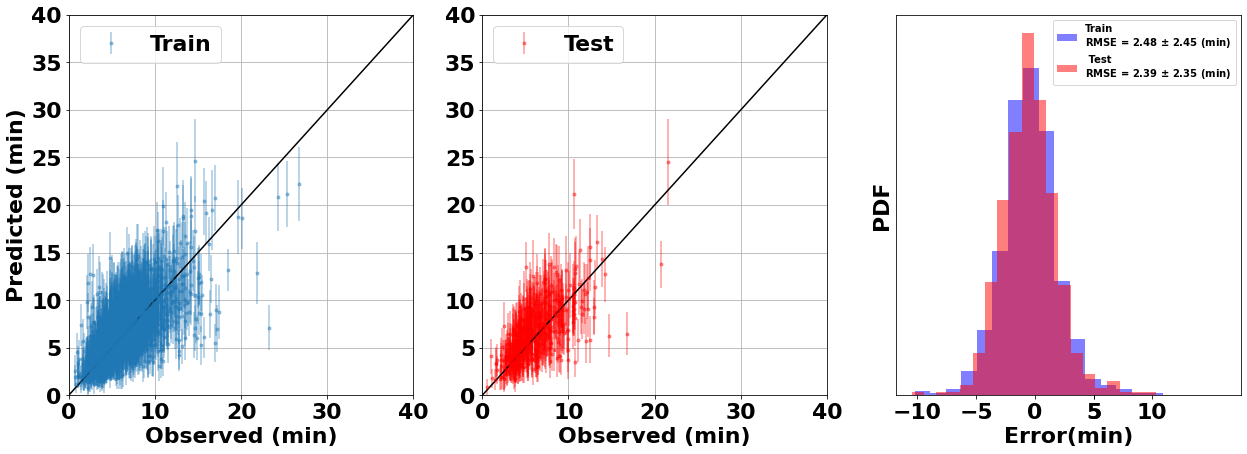

In [44]:
plot_predictions(miles, miles_tst, ppc_test, trace, logdirect = False, logn = True)

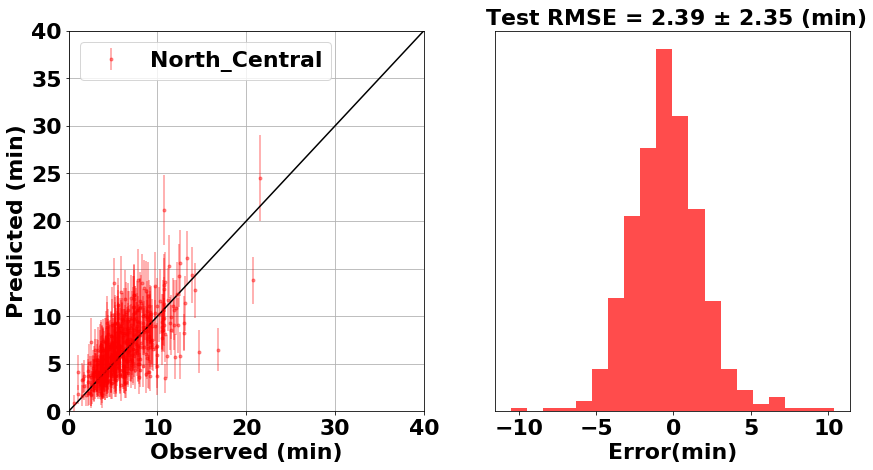

In [6]:
plot_predictions(miles, miles_tst, ppc_test, trace, logdirect = False, logn = True)
# plot_predictions(miles, miles_tst, ppc_test, trace, logdirect = False, logn = True, ax=ax])